### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [325]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [326]:
Paras = {
    'M0':['M0', 'e','Del_n' , 'sqrt_A'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [327]:
sat_var = 2
var_name = 'omega'

In [328]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,omega
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-1.94318871500000001085
2017-11-02 01:00:00,-1.94317699800000021071
2017-11-02 02:00:00,-1.94316299289999983024
2017-11-02 03:00:00,-1.94314589979999996494
2017-11-02 04:00:00,-1.94312502000000009161


# Enter Variable Name

In [329]:
df.columns

Index(['omega'], dtype='object')

In [330]:
#df = df.iloc[5 : , :]

In [331]:
#df.head(7)
#train = df.iloc[48:384,:]
#valid = df.iloc[432:552,:]
test = df.iloc[265:408,:]
test


,omega
Epoch_Time_of_Clock,
2017-11-13 01:00:00,-1.93940204330000010025
2017-11-13 02:00:00,-1.93938157729999982593
2017-11-13 03:00:00,-1.93935927839999999733
2017-11-13 04:00:00,-1.93933550150000000301
2017-11-13 05:00:00,-1.93931707979999989888
2017-11-13 06:00:00,-1.93931640319999987199
2017-11-13 07:00:00,-1.93932495520000003353
2017-11-13 08:00:00,-1.93931422939999986710
2017-11-13 09:00:00,-1.93928235749999999804


# Enter number of entries per day

In [332]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-11 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [333]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [334]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name]]
train.shape


(120, 1)

In [335]:
train.tail(6)

,omega
Epoch_Time_of_Clock,
2017-11-06 18:00:00,-1.94200526620000002431
2017-11-06 19:00:00,-1.94194094509999981568
2017-11-06 20:00:00,-1.94187528919999996546
2017-11-06 21:00:00,-1.94181240659999998499
2017-11-06 22:00:00,-1.94175640509999980488
2017-11-06 23:00:00,-1.94171139270000003840


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [336]:
from sklearn.preprocessing import StandardScaler

y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)


In [337]:
import pickle
file_x = open(var_name+'_X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'_y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [338]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [339]:
train_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -0.91694481345843670272 -0.90748297799835941913   
2017-11-03 00:00:00 -0.90748297799835941913 -0.89345585497777890716   
2017-11-03 01:00:00 -0.89345585497777890716 -0.87250250785814564836   
2017-11-03 02:00:00 -0.87250250785814564836 -0.84232248620214589252   
2017-11-03 03:00:00 -0.84232248620214589252 -0.80202573982902025662   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -0.89345585497777890716 -0.87250250785814564836   
2017-11-03 00:00:00 -0.87250250785814564836 -0.84232248620214589252   
2017-11-03 01:00:00 -0.84232248620214589252 -0.80202573982902025662   
2017-11-03 02:00:00 -0.80202573982902025662 -0.75285732146801509490   
2017-11-03 03:00:00 -0.75285732146801509490 -0.71280025834444238342   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -0.84232248620214589252 -0.80202573982902025662   
2017-11-03 00:00:00 -0.80202573982902025662 -0.75285732146801509490   
2017-11-03 01:00:00 -0.75285732146801509490 -0.71280025834444238342   
2017-11-03 02:00:00 -0.71280025834444238342 -0.71399613078580326242   
2017-11-03 03:00:00 -0.71399613078580326242 -0.73143280456360992847   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -0.75285732146801509490 -0.71280025834444238342   
2017-11-03 00:00:00 -0.71280025834444238342 -0.71399613078580326242   
2017-11-03 01:00:00 -0.71399613078580326242 -0.73143280456360992847   
2017-11-03 02:00:00 -0.73143280456360992847 -0.68532345673718608747   
2017-11-03 03:00:00 -0.68532345673718608747 -0.56480715740387765766   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -0.71399613078580326242 -0.73143280456360992847   
2017-11-03 00:00:00 -0.73143280456360992847 -0.68532345673718608747   
2017-11-03 01:00:00 -0.68532345673718608747 -0.56480715740387765766   
2017-11-03 02:00:00 -0.56480715740387765766 -0.42911845612647697701   
2017-11-03 03:00:00 -0.42911845612647697701 -0.30961346182552990092   

tensor                        ...                                 X  \
feature                       ...                             omega   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-02 23:00:00           ...           -1.27999681938589504604   
2017-11-03 00:00:00           ...           -1.18630780266473201401   
2017-11-03 01:00:00           ...           -1.11166766875106515222   
2017-11-03 02:00:00           ...           -1.05371548110508972407   
2017-11-03 03:00:00           ...           -1.01008917260616803979   

tensor                                                               \
feature                                                               
time step         

In [340]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [341]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.94367251179585043275 1.90805213260168526901   
2017-11-07 01:00:00 1.90805213260168526901 1.79492785689151923556   
2017-11-07 02:00:00 1.79492785689151923556 1.59586865676594791275   
2017-11-07 03:00:00 1.59586865676594791275 1.37558731380046439519   
2017-11-07 04:00:00 1.37558731380046439519 1.26859502877921448416   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.79492785689151923556 1.59586865676594791275   
2017-11-07 01:00:00 1.59586865676594791275 1.37558731380046439519   
2017-11-07 02:00:00 1.37558731380046439519 1.26859502877921448416   
2017-11-07 03:00:00 1.26859502877921448416 1.33568683619599770651   
2017-11-07 04:00:00 1.33568683619599770651 1.55569881815109956058   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.37558731380046439519 1.26859502877921448416   
2017-11-07 01:00:00 1.26859502877921448416 1.33568683619599770651   
2017-11-07 02:00:00 1.33568683619599770651 1.55569881815109956058   
2017-11-07 03:00:00 1.55569881815109956058 1.78770542047365177396   
2017-11-07 04:00:00 1.78770542047365177396 1.78498298054258941470   

tensor                                                             \
feature                                                             
time step                              t+7                    t+8   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.33568683619599770651 1.55569881815109956058   
2017-11-07 01:00:00 1.55569881815109956058 1.78770542047365177396   
2017-11-07 02:00:00 1.78770542047365177396 1.78498298054258941470   
2017-11-07 03:00:00 1.78498298054258941470 1.54003857034569224815   
2017-11-07 04:00:00 1.54003857034569224815 1.28422277237014137441   

tensor                                                             \
feature                                                             
time step                              t+9                   t+10   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.78770542047365177396 1.78498298054258941470   
2017-11-07 01:00:00 1.78498298054258941470 1.54003857034569224815   
2017-11-07 02:00:00 1.54003857034569224815 1.28422277237014137441   
2017-11-07 03:00:00 1.28422277237014137441 1.13418784148127982370   
2017-11-07 04:00:00 1.13418784148127982370 1.08126758885410989564   

tensor                       ...                                X  \
feature                      ...                            omega   
time step                    ...                              t-9   
Epoch_Time_of_Clock          ...                                    
2017-11-07 00:00:00          ...           0.59156842348651528241   
2017-11-07 01:00:00          ...           0.69238603837185141998   
2017-11-07 02:00:00          ...           0.83180876725992380916   
2017-11-07 03:00:00          ...           0.99822610480249540643   
2017-11-07 04:00:00          ...           1.18002669771586132796   

tensor                                                             \
feature                                                             
time step                              t-8                    t-7   
Epoch_Time_of_Clock                                          

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [342]:
#Image('./images/simple_encoder_decoder.png')

In [343]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [344]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 500

In [345]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 ) , return_sequences=True))
model.add(LSTM(LATENT_DIM ) )
model.add(RepeatVector(HORIZON))
#model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [346]:
model.compile(optimizer='RMSprop', loss='mse')

In [347]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 24, 64)            16896     
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                33024     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 24, 64)            0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 1)             65        
_________________________________________________________________
flatten_10 (Flatten)         (None, 24)                0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [348]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2000)

In [349]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [350]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 72 samples
Epoch 1/500
73/73 [==============================] - 4s 50ms/step - loss: 0.3054 - val_loss: 3.2918
Epoch 2/500
73/73 [==============================] - 0s 2ms/step - loss: 0.1462 - val_loss: 0.6707
Epoch 3/500
73/73 [==============================] - 0s 1ms/step - loss: 0.1152 - val_loss: 0.7120
Epoch 4/500
73/73 [==============================] - 0s 2ms/step - loss: 0.1008 - val_loss: 0.9598
Epoch 5/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0902 - val_loss: 1.0917
Epoch 6/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0885 - val_loss: 1.2218
Epoch 7/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0873 - val_loss: 1.3444
Epoch 8/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0864 - val_loss: 1.4550
Epoch 9/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0858 - val_loss: 1.5584
Epoch 10/500
73/73 [==============================] - 0s 2ms/ste

73/73 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 9.7111
Epoch 83/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0722 - val_loss: 9.8979
Epoch 84/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0738 - val_loss: 10.5695
Epoch 85/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 11.7650
Epoch 86/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0781 - val_loss: 10.1589
Epoch 87/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0726 - val_loss: 9.8100
Epoch 88/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0725 - val_loss: 9.7835
Epoch 89/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0732 - val_loss: 10.3207
Epoch 90/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0726 - val_loss: 10.9229
Epoch 91/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0725 - val_loss: 10.3102
Epoch 9

73/73 [==============================] - 0s 1ms/step - loss: 0.0724 - val_loss: 9.1189
Epoch 164/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0752 - val_loss: 8.5637
Epoch 165/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 8.4313
Epoch 166/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0713 - val_loss: 8.5601
Epoch 167/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 8.9073
Epoch 168/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 8.7691
Epoch 169/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0709 - val_loss: 8.3395
Epoch 170/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 8.1837
Epoch 171/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 8.6546
Epoch 172/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0732 - val_loss: 9.2738
Epoc

73/73 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 6.0387
Epoch 245/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0727 - val_loss: 6.6703
Epoch 246/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 7.1747
Epoch 247/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 7.3462
Epoch 248/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 6.3995
Epoch 249/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0699 - val_loss: 6.6470
Epoch 250/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 7.1695
Epoch 251/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 6.6230
Epoch 252/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 5.9125
Epoch 253/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 6.8025
Epoc

73/73 [==============================] - 0s 983us/step - loss: 0.0718 - val_loss: 6.0935
Epoch 326/500
73/73 [==============================] - 0s 959us/step - loss: 0.0697 - val_loss: 6.5889
Epoch 327/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 6.4600
Epoch 328/500
73/73 [==============================] - 0s 985us/step - loss: 0.0705 - val_loss: 5.7294
Epoch 329/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 6.1476
Epoch 330/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 6.6579
Epoch 331/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 6.8025
Epoch 332/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0714 - val_loss: 5.8103
Epoch 333/500
73/73 [==============================] - 0s 919us/step - loss: 0.0709 - val_loss: 6.0495
Epoch 334/500
73/73 [==============================] - 0s 883us/step - loss: 0.0697 - val_loss: 6

73/73 [==============================] - 0s 1ms/step - loss: 0.0717 - val_loss: 6.2666
Epoch 406/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 7.1120
Epoch 407/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0699 - val_loss: 7.0534
Epoch 408/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 6.7503
Epoch 409/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 6.6654
Epoch 410/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 7.0153
Epoch 411/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 6.4106
Epoch 412/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 6.3006
Epoch 413/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 6.7885
Epoch 414/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 6.9525
Epoc

73/73 [==============================] - 0s 950us/step - loss: 0.0709 - val_loss: 6.7891
Epoch 486/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 7.1670
Epoch 487/500
73/73 [==============================] - 0s 3ms/step - loss: 0.0697 - val_loss: 6.4224
Epoch 488/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 6.5664
Epoch 489/500
73/73 [==============================] - 0s 976us/step - loss: 0.0696 - val_loss: 7.0635
Epoch 490/500
73/73 [==============================] - 0s 920us/step - loss: 0.0693 - val_loss: 6.8398
Epoch 491/500
73/73 [==============================] - 0s 987us/step - loss: 0.0694 - val_loss: 6.7428
Epoch 492/500
73/73 [==============================] - 0s 959us/step - loss: 0.0694 - val_loss: 7.1140
Epoch 493/500
73/73 [==============================] - 0s 975us/step - loss: 0.0695 - val_loss: 6.7650
Epoch 494/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss:

In [353]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [354]:
 model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
72/72 [==============================] - 0s 1ms/step - loss: 1.4891
Epoch 2/100
72/72 [==============================] - 0s 2ms/step - loss: 1.9436
Epoch 3/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6697
Epoch 4/100
72/72 [==============================] - 0s 2ms/step - loss: 0.5686
Epoch 5/100
72/72 [==============================] - 0s 2ms/step - loss: 0.6282
Epoch 6/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7522
Epoch 7/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8453
Epoch 8/100
72/72 [==============================] - 0s 2ms/step - loss: 0.9070
Epoch 9/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8205
Epoch 10/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7627
Epoch 11/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7368
Epoch 12/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7237
Epoch 13/100
72/72 [=================



## Evaluate the model

In [355]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 8.92125355263712194187 8.94322922795772967675   
2017-11-14 01:00:00 8.94322922795772967675 8.97205707429925425345   
2017-11-14 02:00:00 8.97205707429925425345 9.00822239371221655801   
2017-11-14 03:00:00 9.00822239371221655801 9.04212881155402925515   
2017-11-14 04:00:00 9.04212881155402925515 9.05517685111073689086   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 8.97205707429925425345 9.00822239371221655801   
2017-11-14 01:00:00 9.00822239371221655801 9.04212881155402925515   
2017-11-14 02:00:00 9.04212881155402925515 9.05517685111073689086   
2017-11-14 03:00:00 9.05517685111073689086 9.05314463110359923803   
2017-11-14 04:00:00 9.05314463110359923803 9.06571669590369921821   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 9.04212881155402925515 9.05517685111073689086   
2017-11-14 01:00:00 9.05517685111073689086 9.05314463110359923803   
2017-11-14 02:00:00 9.05314463110359923803 9.06571669590369921821   
2017-11-14 03:00:00 9.06571669590369921821 9.10273560424971073246   
2017-11-14 04:00:00 9.10273560424971073246 9.15321182260600174629   

tensor                                                             \
feature                                                             
time step                              t+7                    t+8   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 9.05314463110359923803 9.06571669590369921821   
2017-11-14 01:00:00 9.06571669590369921821 9.10273560424971073246   
2017-11-14 02:00:00 9.10273560424971073246 9.15321182260600174629   
2017-11-14 03:00:00 9.15321182260600174629 9.20727141860527176220   
2017-11-14 04:00:00 9.20727141860527176220 9.25724113650928615016   

tensor                                                             \
feature                                                             
time step                              t+9                   t+10   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 9.10273560424971073246 9.15321182260600174629   
2017-11-14 01:00:00 9.15321182260600174629 9.20727141860527176220   
2017-11-14 02:00:00 9.20727141860527176220 9.25724113650928615016   
2017-11-14 03:00:00 9.25724113650928615016 9.29953929454725880532   
2017-11-14 04:00:00 9.29953929454725880532 9.33458646898862376418   

tensor                       ...                                X  \
feature                      ...                            omega   
time step                    ...                              t-9   
Epoch_Time_of_Clock          ...                                    
2017-11-14 00:00:00          ...           8.87510746091574098671   
2017-11-14 01:00:00          ...           8.87937597086732743890   
2017-11-14 02:00:00          ...           8.88125782355213644337   
2017-11-14 03:00:00          ...           8.88167670394937758260   
2017-11-14 04:00:00          ...           8.88155657967923595209   

tensor                                                             \
feature                                                             
time step                              t-8                    t-7   
Epoch_Time_of_Clock                                          

In [356]:
test_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00  8.92125355263712194187  8.94322922795772967675   
2017-11-14 01:00:00  8.94322922795772967675  8.97205707429925425345   
2017-11-14 02:00:00  8.97205707429925425345  9.00822239371221655801   
2017-11-14 03:00:00  9.00822239371221655801  9.04212881155402925515   
2017-11-14 04:00:00  9.04212881155402925515  9.05517685111073689086   
2017-11-14 05:00:00  9.05517685111073689086  9.05314463110359923803   
2017-11-14 06:00:00  9.05314463110359923803  9.06571669590369921821   
2017-11-14 07:00:00  9.06571669590369921821  9.10273560424971073246   
2017-11-14 08:00:00  9.10273560424971073246  9.15321182260600174629   
2017-11-14 09:00:00  9.15321182260600174629  9.20727141860527176220   
2017-11-14 10:00:00  9.20727141860527176220  9.25724113650928615016   
2017-11-14 11:00:00  9.25724113650928615016  9.29953929454725880532   
2017-11-14 12:00:00  9.29953929454725880532  9.33458646898862376418   
2017-11-14 13:00:00  9.33458646898862376418  9.36297734563142114439   
2017-11-14 14:00:00  9.36297734563142114439  9.38530661027557222553   
2017-11-14 15:00:00  9.38530661027557222553  9.40216894871911890164   
2017-11-14 16:00:00  9.40216894871911890164  9.41415961205208517981   
2017-11-14 17:00:00  9.41415961205208517981  9.42187300342840217127   
2017-11-14 18:00:00  9.42187300342840217127  9.42590380864673527128   
2017-11-14 19:00:00  9.42590380864673527128  9.42684699615237420289   
2017-11-14 20:00:00  9.42684699615237420289  9.42529753438872397453   
2017-11-14 21:00:00  9.42529753438872397453  9.42184982650971569740   
2017-11-14 22:00:00  9.42184982650971569740  9.41709855831526887471   
2017-11-14 23:00:00  9.41709855831526887471  9.41163898089415695836   
2017-11-15 00:00:00  9.41163898089415695836  9.40606549740030928319   
2017-11-15 01:00:00  9.40606549740030928319  9.40097279363239302086   
2017-11-15 02:00:00  9.40097279363239302086  9.39705165480631876562   
2017-11-15 03:00:00  9.39705165480631876562  9.39718958573320861660   
2017-11-15 04:00:00  9.39718958573320861660  9.40623536725032138861   
2017-11-15 05:00:00  9.40623536725032138861  9.42367825922616120238   
...                                     ...                     ...   
2017-11-16 18:00:00 10.33775385973810045925 10.39340050933144610212   
2017-11-16 19:00:00 10.39340050933144610212 10.44228882615819387070   
2017-11-16 20:00:00 10.44228882615819387070 10.48194622876809845025   
2017-11-16 21:00:00 10.48194622876809845025 10.50989985306742902083   
2017-11-16 22:00:00 10.50989985306742902083 10.52367740025130338211   
2017-11-16 23:00:00 10.52367740025130338211 10.52080544093338154710   
2017-11-17 00:00:00 10.52080544093338154710 10.49881195895602559176   
2017-11-17 01:00:00 10.49881195895602559176 10.45522380757763158954   
2017-11-17 02:00:00 10.45522380757763158954 10.38856444753436214512   
2017-11-17 03:00:00 10.38856444753436214512 10.32027309328709918645   
2017-11-17 04:00:00 10.32027309328709918645 10.29339493451362130827   
2017-11-17 05:00:00 10.29339493451362130827 10.32187512708427057362   
2017-11-17 06:00:00 10.32187512708427057362 10.38887253095662899227   
2017-11-17 07:00:00 10.38887253095662899227 10.46036512634458581772   
2017-11-17 08:00:00 10.46036512634458581772 10.48854345368974527730   
2017-11-17 09:00:00 10.48854345368974527730 10.47283967850250085974   
2017-11-17 10:00:00 10.47283967850250085974 10.45950475392402800878   
2017-11-17 11:00:00 10.45950475392402800878 10.47124612406565447031   
2017-11-17 12:00:00 10.47124612406565447031 10.50514632370943424178   
2017-11-17 13:00:00 10.50514632370943424178 10.55717256912010526548   
2017-11-17 14:00:00 10.55717256912010526548 10.62329292449724604808   
2017-11-17 15:00:00 10.6

In [357]:
test_inputs.dataframe.shape

(96, 48)

In [358]:
predictions = model.predict(test_inputs['X'])

In [359]:
predictions

array([[5.9463444, 5.9463444, 5.9463444, ..., 5.9463444, 5.9463444,
        5.9463444],
       [5.945632 , 5.945632 , 5.945632 , ..., 5.945632 , 5.945632 ,
        5.945632 ],
       [5.945312 , 5.945312 , 5.945312 , ..., 5.945312 , 5.945312 ,
        5.945312 ],
       ...,
       [5.953362 , 5.953362 , 5.953362 , ..., 5.953362 , 5.953362 ,
        5.953362 ],
       [5.955013 , 5.955013 , 5.955013 , ..., 5.955013 , 5.955013 ,
        5.955013 ],
       [5.95607  , 5.95607  , 5.95607  , ..., 5.95607  , 5.95607  ,
        5.95607  ]], dtype=float32)

In [360]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-14 00:00:00  t+1 -1.94025462058873321425 -1.93920209689999989422
1 2017-11-14 01:00:00  t+1 -1.94025487263417995010 -1.93919432190000007310
2 2017-11-14 02:00:00  t+1 -1.94025498583531441632 -1.93918412259999994873
3 2017-11-14 03:00:00  t+1 -1.94025496289141829998 -1.93917132729999996954
4 2017-11-14 04:00:00  t+1 -1.94025481797372156834 -1.93915933119999994716
               timestamp     h              prediction                  actual
2299 2017-11-17 19:00:00  t+24 -1.94025372611419588686 -1.93830281699999984468
2300 2017-11-17 20:00:00  t+24 -1.94025287887709163570 -1.93826782509999984150
2301 2017-11-17 21:00:00  t+24 -1.94025213775550708917 -1.93823441070000002107
2302 2017-11-17 22:00:00  t+24 -1.94025155369838731012 -1.93820435619999997812
2303 2017-11-17 23:00:00  t+24 -1.94025117967914018102 -1.93817944389999996524
(2304, 4)


In [361]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    -0.00072122480408438568
t+10   -0.00075610229421413117
t+11   -0.00075991345663928289
t+12   -0.00076354088516281712
t+13   -0.00076698756492725461
t+14   -0.00077033298822095622
t+15   -0.00077364956448172520
t+16   -0.00077699898726313560
t+17   -0.00078043223502186011
t+18   -0.00078398957058876636
t+19   -0.00078770054058501947
t+2    -0.00072553542275377808
t+20   -0.00079158397549666587
t+21   -0.00079564798734187917
t+22   -0.00079988996882165292
t+23   -0.00080429659085311668
t+24   -0.00080884380296018061
t+3    -0.00072977623833975431
t+4    -0.00073387662940704781
t+5    -0.00073775961898769069
t+6    -0.00074141250095347271
t+7    -0.00074495326451931479
t+8    -0.00074853708914779089
t+9    -0.00075225795034569579
Name: APE, dtype: float64

In [362]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.0014827534276307377

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

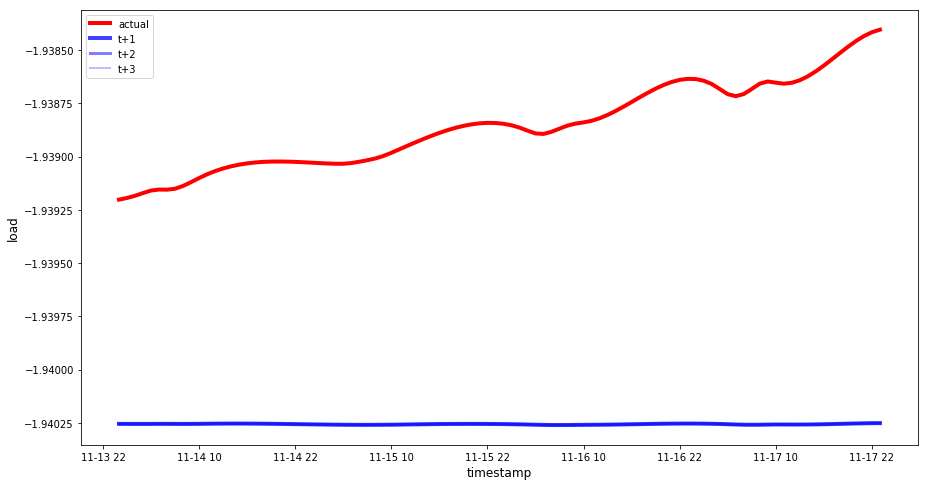

In [363]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [364]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [365]:
new_df = pd.DataFrame()

In [366]:
columns = Paras[var_name] 

In [367]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [368]:
new_df = new_df.dropna( how = 'any')

In [369]:
new_df

,omega
Epoch_Time_of_Clock,
2017-11-21 00:00:00,-1.93769371360000008941
2017-11-21 01:00:00,-1.93767848199999992431
2017-11-21 02:00:00,-1.93767233699999996688
2017-11-21 03:00:00,-1.93767702650000006592
2017-11-21 04:00:00,-1.93769399860000013369
2017-11-21 05:00:00,-1.93771780869999998842
2017-11-21 06:00:00,-1.93773615020000011810
2017-11-21 07:00:00,-1.93773712460000013813
2017-11-21 08:00:00,-1.93771062990000020321


In [370]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [371]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [372]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [373]:
new_df.index= date

In [374]:
new_df.columns

Index(['omega'], dtype='object')

In [375]:
print(new_df)
print(new_df.columns)

                                      omega
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -1.93769371360000008941
2017-11-22 01:00:00 -1.93767848199999992431
2017-11-22 02:00:00 -1.93767233699999996688
2017-11-22 03:00:00 -1.93767702650000006592
2017-11-22 04:00:00 -1.93769399860000013369
2017-11-22 05:00:00 -1.93771780869999998842
2017-11-22 06:00:00 -1.93773615020000011810
2017-11-22 07:00:00 -1.93773712460000013813
2017-11-22 08:00:00 -1.93771062990000020321
2017-11-22 09:00:00 -1.93767163190000002437
2017-11-22 10:00:00 -1.93765864830000023034
2017-11-22 11:00:00 -1.93767710849999996725
2017-11-22 12:00:00 -1.93769892590000014643
2017-11-22 13:00:00 -1.93770971159999993993
2017-11-22 14:00:00 -1.93771026000000001765
2017-11-22 15:00:00 -1.93770202580000017178
2017-11-22 16:00:00 -1.93768646360000018625
2017-11-22 17:00:00 -1.93766502800000006701
2017-11-22 18:00:00 -1.93763917380000005863
2017-11-22 19:00:00 -1.93761035550000015881
2017-11-22 20:00:00 -1.937580027

In [376]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[['e', 'OMEGA', 'omega']] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), ['e', 'OMEGA', 'omega'])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

KeyError: "['e' 'OMEGA'] not in index"

In [ ]:
print(new_new_df)
print(inputs['X'])

In [ ]:
predictions = model.predict(inputs['X'])

In [377]:
predictions

array([[5.9463444, 5.9463444, 5.9463444, ..., 5.9463444, 5.9463444,
        5.9463444],
       [5.945632 , 5.945632 , 5.945632 , ..., 5.945632 , 5.945632 ,
        5.945632 ],
       [5.945312 , 5.945312 , 5.945312 , ..., 5.945312 , 5.945312 ,
        5.945312 ],
       ...,
       [5.953362 , 5.953362 , 5.953362 , ..., 5.953362 , 5.953362 ,
        5.953362 ],
       [5.955013 , 5.955013 , 5.955013 , ..., 5.955013 , 5.955013 ,
        5.955013 ],
       [5.95607  , 5.95607  , 5.95607  , ..., 5.95607  , 5.95607  ,
        5.95607  ]], dtype=float32)

In [378]:
print(predictions.shape)


(96, 24)


In [379]:
results = predictions[-1, :]

In [380]:
results

array([5.95607, 5.95607, 5.95607, 5.95607, 5.95607, 5.95607, 5.95607,
       5.95607, 5.95607, 5.95607, 5.95607, 5.95607, 5.95607, 5.95607,
       5.95607, 5.95607, 5.95607, 5.95607, 5.95607, 5.95607, 5.95607,
       5.95607, 5.95607, 5.95607], dtype=float32)

In [381]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,omega
0,5.95606994628906250000
1,5.95606994628906250000
2,5.95606994628906250000
3,5.95606994628906250000
4,5.95606994628906250000
5,5.95606994628906250000
6,5.95606994628906250000
7,5.95606994628906250000
8,5.95606994628906250000
9,5.95606994628906250000


In [382]:
res_df.index = date
res_df

,omega
Epoch_Time_of_Clock,
2017-11-22 00:00:00,5.95606994628906250000
2017-11-22 01:00:00,5.95606994628906250000
2017-11-22 02:00:00,5.95606994628906250000
2017-11-22 03:00:00,5.95606994628906250000
2017-11-22 04:00:00,5.95606994628906250000
2017-11-22 05:00:00,5.95606994628906250000
2017-11-22 06:00:00,5.95606994628906250000
2017-11-22 07:00:00,5.95606994628906250000
2017-11-22 08:00:00,5.95606994628906250000


In [383]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [384]:
# final generated ouput
res_df['actual'] = Actual

In [385]:
res_df.to_csv('SA2omega.csv')